In [22]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, classification_report, f1_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

Importa il dataset

In [23]:
data = pd.read_csv('Data/25day_dataset.csv')

Funzione di Preprocessing per la verifica sulla presenza di dati NULL all'interno del dataset

In [24]:
def verify_Null(data):
    print("Verifying if the data contains NULL values...")
    x= data.isnull()
    #Conta i record in cui compare True
    nl=len(x[x.eq(True).any(1)])
    if nl>0:
        print(f"A total of {nl} NULL values have been found")
        return True
    else:
        print("No NULL values found in the dataset")
        return False
verify_Null(data)

Verifying if the data contains NULL values...
No NULL values found in the dataset


False

Funzione di Preprocessing che prende i percentili piu alti e piu bassi dello 0,001% ed elimina i record con valori maggiori o minori.  

In [25]:
def percentile_Preprocessing(data):
    #DF per i valori da eliminare
    to_drop= pd.DataFrame()
    #Prendiamo lo 0.001 percento di valori piu grandi e piu piccoli per ogni colonna e aggiungili ad un DF temporaneo
    for col in data.columns[1:]:
        print(f"Working on {col} column...")
        q= data[f'{col}'].quantile(0.99999)
        q1= data[f'{col}'].quantile(0.001)
        Q= data[(data[f'{col}']>q) | (data[f'{col}']<q1)]
        #Aggiungi il DF temporaneo al DF per i valori da eliminare senza i duplicati 
        to_drop= pd.concat([to_drop,Q]).drop_duplicates()
        print(f"Removing {len(Q)} values...")
    #Ripulisci dai valori scelti il DF di partenza
    data.drop(to_drop.index, inplace=True)
    print(f"Total values removed: {len(to_drop)} values")
    print(f"Total values remaining in dataset: {len(data)} values")

Elimino i campioni con Active power minore del consumo degli elettrodomestici. Metto soglia a 0.1 (Ha senso?)

In [26]:
def active_Power_Preprocessing(df, threshold):
    print("Deleting all records with Active Power lower then the power consumed by one of the machines")
    print(f"The chosen threshold is {threshold}")
    #Prendi i record con Active power minore del consumo degli elettrodomestici con una tolleranza definita dalla soglia
    x = df[(df['ActivePower'] + threshold < df['dishwasher']) | 
           (df['ActivePower'] + threshold < df['wahing_machine']) | 
           (df['ActivePower'] + threshold < df['oven'])] 
    print(f"{len(x)} records have been deleted")
    df.drop(x.index, inplace= True)
    print(f"A total of {len(df)} records remain in the dataset")

Le maggiori variabilita si hanno per 'ActivePower'e 'ReactivePower' gli altri neanche li considero

Facciamo Outlier detection su valori estremi per le prime due colonne eliminando valori alti di potenza attiva 
e reattiva quando i 3 elettrodomestici sono spenti. (I valori soglia sono da rivedere)

In [64]:
def all_Off_Preprocessing(df):
    print("Deleting high values of Active Power or Reactive Power with all devices OFF..")
    x = df[(df['ActivePower']>0.6) | (df['ReactivePower']<-0.3) | (df['ReactivePower']>=0.7)] 
    outliers_AP= x[(x['wahing_machine']==0) & (x['dishwasher']==0) & (x['oven']==0)]
    print(f"Deleting a total of {len(outliers_AP)} values")
    df.drop(outliers_AP.index, axis=0, inplace=True)

Si etichetta il dataset con 4 classi:

    1) Tutti spenti [0]
    2) Solo lavatrice accesa [1]
    3) Solo lavastoviglie accesa [2]
    4) Solo forno acceso [3]

In [50]:
label = []
for i in range(len(data)):
    if data['wahing_machine'].iloc[i]==0 and data['dishwasher'].iloc[i]==0 and data['oven'].iloc[i]==0:
        label.append(0)
    elif data['wahing_machine'].iloc[i]>0:
        label.append(1)
    elif data['dishwasher'].iloc[i]>0:
        label.append(2)
    elif data['oven'].iloc[i]>0:
        label.append(3)
data['Class'] = label

In [29]:
#Droppa le colonne che non servono piu 
#data.drop(['wahing_machine', 'dishwasher', 'oven'], axis=1, inplace=True)

di seguito le istruzioni fronite per effettuare il corretto folding:

Test set fold 01: 
Tutte le misure del giorno 2022-01-01


Test set fold 02: 
Tutte le misure del giorno 2022-01-02

Test set fold 03: 
Tutte le misure del giorno 2022-01-03

…..


Test set fold 09: 
Tutte le misure del giorno 2022-01-10
Tutte le misure del giorno 2022-01-11

Test set fold 10: 
Tutte le misure del giorno 2022-01-12
Tutte le misure del giorno 2022-01-13 (dati disponibili fino alle 03:16)


In [30]:
Test_set1 =data[data['DateTime'].str.startswith('2022-01-01')]
Test_set2 =data[data['DateTime'].str.startswith('2022-01-02')]
Test_set3 =data[data['DateTime'].str.startswith('2022-01-03')]
Test_set4 =data[data['DateTime'].str.startswith('2022-01-04')]
Test_set5 =data[data['DateTime'].str.startswith('2022-01-05')]
Test_set6 =data[data['DateTime'].str.startswith('2022-01-06')]
Test_set7 =data[data['DateTime'].str.startswith('2022-01-07')]
Test_set8 =data[(data['DateTime'].str.startswith('2022-01-08')) | (data['DateTime'].str.startswith('2022-01-09'))]
Test_set9 =data[(data['DateTime'].str.startswith('2022-01-10')) | (data['DateTime'].str.startswith('2022-01-11'))]
Test_set10 =data[(data['DateTime'].str.startswith('2022-01-12')) | (data['DateTime'].str.startswith('2022-01-13'))]
test_set_list= [Test_set1, Test_set2, Test_set3, Test_set4, Test_set5, Test_set6, Test_set7, Test_set8, Test_set9, Test_set10]

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import time
start = time.time()
f_score={}
recall={}
for i in range(0,9):
    #Crea il Training set togliendo dal dataset il Test set
    Test_set= test_set_list[i]
    Training_set= data.drop(Test_set.index, axis=0)
    
    #Preprocessing sul Training set 
    active_Power_Preprocessing(Training_set, 0.0001)
    all_Off_Preprocessing(Training_set)
    
    #Assegna x e y di training togliendo le colonne non utili
    X= Training_set.drop(['DateTime', 'Class', 'wahing_machine', 'dishwasher', 'oven'], axis=1)
    y= Training_set.Class
    one= int((y.values == 1).sum()*0.75)
    two= int((y.values == 2).sum()*0.75)
    three= int((y.values == 3).sum()*0.75)
    #Fai undersample sulle x e y di train
    n= 200000 - one - two - three
    undersample = RandomUnderSampler(sampling_strategy={0: n, 1: one, 2: two, 3: three})
    X_new, y_new = undersample.fit_resample(X, y)
    
    #Fitta il modello con una RandomForest
    clf = RandomForestClassifier(max_depth=10, n_estimators=30)
    clf.fit(X_new, y_new)
    y_preds= clf.predict(Test_set.drop(['DateTime', 'Class', 'wahing_machine', 'dishwasher', 'oven'], axis=1))
    
    #Stampa le statistiche per la fold e memorizza le metriche di f1score e recall
    print("CM:\n" + str(confusion_matrix(Test_set.Class,y_preds)) + "\n")
    print(classification_report(Test_set.Class,y_preds))
    r = recall_score(Test_set.Class,y_preds, average= None) 
    f = f1_score(Test_set.Class,y_preds, average= None)
    f_score[i] = f
    recall[i] = r 
    
end = time.time()
print(f"Time elapsed: {end - start}")

Deleting all records with Active Power lower then the power consumed by one of the machines
The chosen threshold is 0.0001
4956 records have been deleted
A total of 2068644 records remain in the dataset
Deleting high values of Active Power or Reactive Power with all devices OFF..
Deleting a total of 766 values
CM:
[[80926   523   182    34]
 [   69  3984     0     0]
 [    0     0     0     0]
 [  143     0     0   539]]

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     81665
           1       0.88      0.98      0.93      4053
           2       0.00      0.00      0.00         0
           3       0.94      0.79      0.86       682

    accuracy                           0.99     86400
   macro avg       0.71      0.69      0.70     86400
weighted avg       0.99      0.99      0.99     86400



C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Deleting all records with Active Power lower then the power consumed by one of the machines
The chosen threshold is 0.0001
4824 records have been deleted
A total of 2068776 records remain in the dataset
Deleting high values of Active Power or Reactive Power with all devices OFF..
Deleting a total of 765 values
CM:
[[77065   971   156    77]
 [  468  6539     1     0]
 [    0     0     0     0]
 [   79     0     0  1044]]

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     78269
           1       0.87      0.93      0.90      7008
           2       0.00      0.00      0.00         0
           3       0.93      0.93      0.93      1123

    accuracy                           0.98     86400
   macro avg       0.70      0.71      0.71     86400
weighted avg       0.98      0.98      0.98     86400



C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

In [85]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import time
start = time.time()
f_score={}
recall={}
for i in range(0,9):
    #Crea il Training set togliendo dal dataset il Test set
    Test_set= test_set_list[i]
    Training_set= data.drop(Test_set.index, axis=0)
    
    #Preprocessing sul Training set 
    active_Power_Preprocessing(Training_set, 0.0001)
    all_Off_Preprocessing(Training_set)
    
    #Assegna x e y di training togliendo le colonne non utili
    X= Training_set.drop(['DateTime', 'Class', 'wahing_machine', 'dishwasher', 'oven'], axis=1)
    y= Training_set.Class
    
    #Fai undersample sulle x e y di train
    n= 200000 - (y.values == 1).sum() - (y.values == 3).sum() - (y.values == 2).sum()
    undersample = RandomUnderSampler(sampling_strategy={0: n, 1: (y.values == 1).sum(), 2: (y.values == 2).sum(), 3: (y.values == 3).sum()})
    X_new, y_new = undersample.fit_resample(X, y)
    
    #Fitta il modello con una RandomForest
    clf = RandomForestClassifier(max_depth=10, n_estimators=50)
    clf.fit(X_new, y_new)
    y_preds= clf.predict(Test_set.drop(['DateTime', 'Class', 'wahing_machine', 'dishwasher', 'oven'], axis=1))
    
    #Stampa le statistiche per la fold e memorizza le metriche di f1score e recall
    print("CM:\n" + str(confusion_matrix(Test_set.Class,y_preds)) + "\n")
    print(classification_report(Test_set.Class,y_preds))
    r = recall_score(Test_set.Class,y_preds, average= None) 
    f = f1_score(Test_set.Class,y_preds, average= None)
    f_score[i] = f
    recall[i] = r 
    
end = time.time()
print(f"Time elapsed: {end - start}")

Deleting all records with Active Power lower then the power consumed by one of the machines
The chosen threshold is 0.0001
4956 records have been deleted
A total of 2068644 records remain in the dataset
Deleting high values of Active Power or Reactive Power with all devices OFF..
Deleting a total of 766 values
CM:
[[79536   593  1469    67]
 [   50  4003     0     0]
 [    0     0     0     0]
 [  143     0     0   539]]

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     81665
           1       0.87      0.99      0.93      4053
           2       0.00      0.00      0.00         0
           3       0.89      0.79      0.84       682

    accuracy                           0.97     86400
   macro avg       0.69      0.69      0.69     86400
weighted avg       0.99      0.97      0.98     86400



C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Deleting all records with Active Power lower then the power consumed by one of the machines
The chosen threshold is 0.0001
4824 records have been deleted
A total of 2068776 records remain in the dataset
Deleting high values of Active Power or Reactive Power with all devices OFF..
Deleting a total of 765 values
CM:
[[76571  1038   454   206]
 [  416  6590     1     1]
 [    0     0     0     0]
 [   70     0     0  1053]]

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     78269
           1       0.86      0.94      0.90      7008
           2       0.00      0.00      0.00         0
           3       0.84      0.94      0.88      1123

    accuracy                           0.97     86400
   macro avg       0.67      0.71      0.69     86400
weighted avg       0.98      0.97      0.98     86400



C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Deleting all records with Active Power lower then the power consumed by one of the machines
The chosen threshold is 0.0001
4967 records have been deleted
A total of 2068633 records remain in the dataset
Deleting high values of Active Power or Reactive Power with all devices OFF..
Deleting a total of 763 values
CM:
[[74530  5571   221   773]
 [   22   992     0    10]
 [  596   228  2753     0]
 [    0     0     0   704]]

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     81095
           1       0.15      0.97      0.25      1024
           2       0.93      0.77      0.84      3577
           3       0.47      1.00      0.64       704

    accuracy                           0.91     86400
   macro avg       0.63      0.91      0.67     86400
weighted avg       0.97      0.91      0.94     86400

Deleting all records with Active Power lower then the power consumed by one of the machines
The chosen threshold is 0.0001
4957 records hav

C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Deleting all records with Active Power lower then the power consumed by one of the machines
The chosen threshold is 0.0001
4948 records have been deleted
A total of 2068652 records remain in the dataset
Deleting high values of Active Power or Reactive Power with all devices OFF..
Deleting a total of 766 values
CM:
[[81968   763     3     1]
 [   82  3583     0     0]
 [    0     0     0     0]
 [    0     0     0     0]]

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     82735
           1       0.82      0.98      0.89      3665
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.99     86400
   macro avg       0.46      0.49      0.47     86400
weighted avg       0.99      0.99      0.99     86400



C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Deleting all records with Active Power lower then the power consumed by one of the machines
The chosen threshold is 0.0001
4100 records have been deleted
A total of 2069500 records remain in the dataset
Deleting high values of Active Power or Reactive Power with all devices OFF..
Deleting a total of 451 values
CM:
[[80382  1551   429    60]
 [    0     0     0     0]
 [   53   484  3440     1]
 [    0     0     0     0]]

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     82422
           1       0.00      0.00      0.00         0
           2       0.89      0.86      0.88      3978
           3       0.00      0.00      0.00         0

    accuracy                           0.97     86400
   macro avg       0.47      0.46      0.47     86400
weighted avg       0.99      0.97      0.98     86400



C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Deleting all records with Active Power lower then the power consumed by one of the machines
The chosen threshold is 0.0001
4771 records have been deleted
A total of 2068829 records remain in the dataset
Deleting high values of Active Power or Reactive Power with all devices OFF..
Deleting a total of 629 values
CM:
[[79656   589   196   515]
 [  163  3095     0     0]
 [    0     0     0     0]
 [  626     2    31  1527]]

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     80956
           1       0.84      0.95      0.89      3258
           2       0.00      0.00      0.00         0
           3       0.75      0.70      0.72      2186

    accuracy                           0.98     86400
   macro avg       0.64      0.66      0.65     86400
weighted avg       0.98      0.98      0.98     86400



C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Deleting all records with Active Power lower then the power consumed by one of the machines
The chosen threshold is 0.0001
4655 records have been deleted
A total of 1982545 records remain in the dataset
Deleting high values of Active Power or Reactive Power with all devices OFF..
Deleting a total of 766 values
CM:
[[158743   1007    638    529]
 [   449   6994      1      0]
 [  1200    301   2131      1]
 [   381     59      0    366]]

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    160917
           1       0.84      0.94      0.89      7444
           2       0.77      0.59      0.67      3633
           3       0.41      0.45      0.43       806

    accuracy                           0.97    172800
   macro avg       0.75      0.74      0.74    172800
weighted avg       0.97      0.97      0.97    172800

Deleting all records with Active Power lower then the power consumed by one of the machines
The chosen threshold is 0.0001


C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

In [86]:
import numpy as np
d= pd.DataFrame.from_dict(f_score, orient='index').replace(0, np.nan)
print(d.mean(axis=0, skipna=True))
d= pd.DataFrame.from_dict(recall, orient='index').replace(0, np.nan)
d.mean(axis=0, skipna=True)


0    0.985438
1    0.794616
2    0.794292
3    0.708227
dtype: float64


0    0.977010
1    0.961767
2    0.740321
3    0.722434
dtype: float64

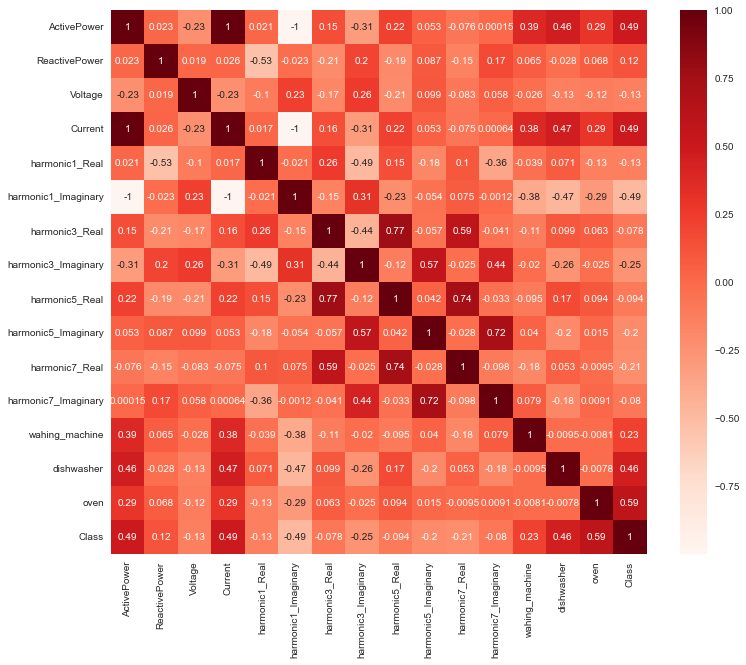

In [365]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

C:\Users\massi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


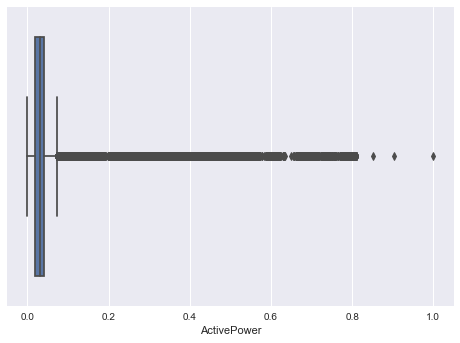

C:\Users\massi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


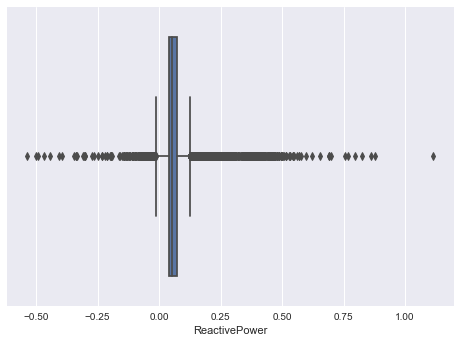

C:\Users\massi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


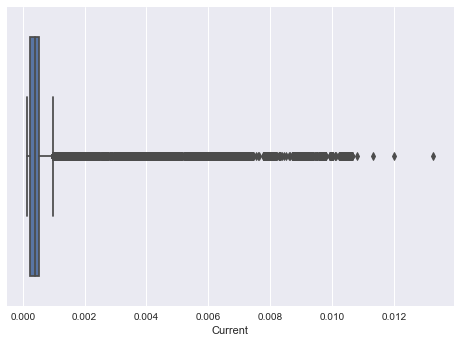

In [68]:
l= ['ActivePower', 'ReactivePower']
for plot in l:   
    ax = sns.boxplot(data[plot])
    plt.show()

In [ ]:
#Boxplot
ax = sns.boxplot(data=data)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

In [ ]:
data.describe()